In [9]:
# Change notebook width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [1]:
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional, Iterable, Mapping, Sequence
from rl.markov_decision_process import *
from rl.markov_process import *
from rl.distribution import *
from rl.dynamic_programming import *
import pprint as pp
import numpy as np
import itertools
import time

# Order Book Code

In [2]:
from __future__ import annotations

from dataclasses import dataclass, replace
from typing import Sequence, Tuple, Optional, List


@dataclass(frozen=True)
class DollarsAndShares:

    dollars: float
    shares: int


PriceSizePairs = Sequence[DollarsAndShares]


@dataclass(frozen=True)
class OrderBook:

    descending_bids: PriceSizePairs
    ascending_asks: PriceSizePairs

    def bid_price(self) -> float:
        return self.descending_bids[0].dollars

    def ask_price(self) -> float:
        return self.ascending_asks[0].dollars

    def mid_price(self) -> float:
        return (self.bid_price() + self.ask_price()) / 2

    def bid_ask_spread(self) -> float:
        return self.ask_price() - self.bid_price()

    def market_depth(self) -> float:
        return self.ascending_asks[-1].dollars - self.descending_bids[-1].dollars
            

    @staticmethod
    def eat_book(
        ps_pairs: PriceSizePairs,
        shares: int
    ) -> Tuple[DollarsAndShares, PriceSizePairs]:
        '''
        Returned DollarsAndShares represents the pair of
        dollars transacted and the number of shares transacted
        on ps_pairs (with number of shares transacted being less
        than or equal to the input shares).
        Returned PriceSizePairs represents the remainder of the
        ps_pairs after the transacted number of shares have eaten into
        the input ps_pairs.
        '''
        rem_shares: int = shares
        dollars: float = 0.
        for i, d_s in enumerate(ps_pairs):
            this_price: float = d_s.dollars
            this_shares: int = d_s.shares
            dollars += this_price * min(rem_shares, this_shares)
            if rem_shares < this_shares:
                return (
                    DollarsAndShares(dollars=dollars, shares=shares),
                    [DollarsAndShares(
                        dollars=this_price,
                        shares=this_shares - rem_shares
                    )] + list(ps_pairs[i+1:])
                )
            else:
                rem_shares -= this_shares

        return (DollarsAndShares(dollars=dollars, shares=shares - rem_shares), [])
            
            
    
    def buy_market_order(
        self,
        shares: int
                            ) -> Tuple[DollarsAndShares, OrderBook]:
        """
        Buy a specified number of shares at the lowest asks available
        """
        
        d_s, rem_asks = OrderBook.eat_book(
            self.ascending_asks,
            shares
        )
        return (d_s, replace(self, ascending_asks=rem_asks))
    
    
    
    def sell_market_order(
        self,
        shares: int
                                        ) -> Tuple[DollarsAndShares, OrderBook]:
        """
        Sell a specified number of shares at the highest bids available
        """
        d_s, rem_bids = OrderBook.eat_book(
            self.descending_bids,
            shares
        )
        return (d_s, replace(self, descending_bids=rem_bids))
    
    
    
    def buy_limit_order(self, price: float, shares: int) -> Tuple[DollarsAndShares, OrderBook]:
        """
        Buys a specified number of shares but only at a specific selling price or lower

        If the price is right, processes the transaction
        Else adds the order/remaining orders to the order book
        """
            
        index: Optional[int] = next((i for i, d_s
                                     in enumerate(self.ascending_asks)
                                     if d_s.dollars > price), None)
            
        eligible_asks: PriceSizePairs = self.ascending_asks if index is None else self.ascending_asks[:index]              
            
        ineligible_asks: PriceSizePairs = [] if index is None else self.ascending_asks[index:]
            

        d_s, rem_asks = OrderBook.eat_book(eligible_asks, shares)
        new_asks: PriceSizePairs = list(rem_asks) + list(ineligible_asks)
        rem_shares: int = shares - d_s.shares

        if rem_shares > 0:
            new_bids: List[DollarsAndShares] = list(self.descending_bids)
            index1: Optional[int] = next((i for i, d_s
                                          in enumerate(new_bids)
                                          if d_s.dollars <= price), None)
            if index1 is None:
                new_bids.append(DollarsAndShares(
                    dollars=price,
                    shares=rem_shares
                ))
            elif new_bids[index1].dollars != price:
                new_bids.insert(index1, DollarsAndShares(
                    dollars=price,
                    shares=rem_shares
                ))
            else:
                new_bids[index1] = DollarsAndShares(
                    dollars=price,
                    shares=new_bids[index1].shares + rem_shares
                )
            return d_s, replace(
                self,
                ascending_asks=new_asks,
                descending_bids=new_bids
            )
        else:
            return d_s, replace(
                self,
                ascending_asks=new_asks
            )
        
    
    def sell_limit_order(self, price: float, shares: int) -> Tuple[DollarsAndShares, OrderBook]:
        """
        Sells a specified number of shares but only at a specific buying price or higher

        If the price is right, processes the transaction
        Else adds the order/remaining orders to the order book
        """    
            
        index: Optional[int] = next((i for i, d_s
                                     in enumerate(self.descending_bids)
                                     if d_s.dollars < price), None)
        eligible_bids: PriceSizePairs = self.descending_bids \
            if index is None else self.descending_bids[:index]
        ineligible_bids: PriceSizePairs = [] if index is None else \
            self.descending_bids[index:]

        d_s, rem_bids = OrderBook.eat_book(eligible_bids, shares)
        new_bids: PriceSizePairs = list(rem_bids) + list(ineligible_bids)
        rem_shares: int = shares - d_s.shares

        if rem_shares > 0:
            new_asks: List[DollarsAndShares] = list(self.ascending_asks)
            index1: Optional[int] = next((i for i, d_s
                                          in enumerate(new_asks)
                                          if d_s.dollars >= price), None)
            if index1 is None:
                new_asks.append(DollarsAndShares(
                    dollars=price,
                    shares=rem_shares
                ))
            elif new_asks[index1].dollars != price:
                new_asks.insert(index1, DollarsAndShares(
                    dollars=price,
                    shares=rem_shares
                ))
            else:
                new_asks[index1] = DollarsAndShares(
                    dollars=price,
                    shares=new_asks[index1].shares + rem_shares
                )
                
            return d_s, OrderBook( ascending_asks=new_asks, descending_bids=new_bids)

        else:
            return d_s, replace(self, descending_bids=new_bids)

        
        

    def pretty_print_order_book(self) -> None:
        """
        Prints the order book nicely
        """
        from pprint import pprint
        print()
        print("Bids")
        pprint(self.descending_bids)
        print()
        print("Asks")
        print()
        pprint(self.ascending_asks)
        print()

    def display_order_book(self) -> None:
        """
        Prints a plot of the order book
        Dimitri's note: I added the extra paremeters so that it displays nicer with my monitor setup
        """
        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = [12, 8] # Chnages default plot size
        plt.rcParams.update({'font.size': 15})   # Changes default font size 22
        plt.rcParams.update({'figure.facecolor':'white'}) # Makes plot background white
        fig, ax = plt.subplots()
        
        
        bid_prices = [d_s.dollars for d_s in self.descending_bids]
        bid_shares = [d_s.shares for d_s in self.descending_bids]
#         min_price = min(bid_prices)
        if self.descending_bids:
            plt.bar(bid_prices, bid_shares, color='blue')

        ask_prices = [d_s.dollars for d_s in self.ascending_asks]
        ask_shares = [d_s.shares for d_s in self.ascending_asks]
#         max_price = max(bid_prices)
        if self.ascending_asks:
            plt.bar(ask_prices, ask_shares, color='red')

        all_prices = sorted(bid_prices + ask_prices)
        all_ticks = ["%d" % x for x in all_prices]
        plt.xticks(all_prices, all_ticks)
        plt.grid(axis='y')
        plt.xlabel("Prices")
        plt.ylabel("Number of Shares")
        plt.title("Order Book")
#         spacer = 20
#         print(min_price, max_price)
#         plt.xlim((min_price - spacer, max_price + spacer))
#         plt.tight_layout()            # Added this in and it worked
        fig.autofmt_xdate()
        
        # Show Time Baby
        plt.show()

# OrderBook Main

In [3]:
# from numpy.random import poisson

# bids: PriceSizePairs = [DollarsAndShares(
#     dollars=x,
#     shares=poisson(100. - (100 - x) * 10)
# ) for x in range(100, 90, -1)]
# asks: PriceSizePairs = [DollarsAndShares(
#     dollars=x,
#     shares=poisson(100. - (x - 105) * 10)
# ) for x in range(105, 115, 1)]

# ob0: OrderBook = OrderBook(descending_bids=bids, ascending_asks=asks)
# ob0.pretty_print_order_book()
# ob0.display_order_book()

# print("Sell Limit Order of (107, 40)")
# print()
# d_s1, ob1 = ob0.sell_limit_order(107, 40)
# proceeds1: float = d_s1.dollars
# shares_sold1: int = d_s1.shares
# print(f"Sales Proceeds = {proceeds1:.2f}, Shares Sold = {shares_sold1:d}")
# ob1.pretty_print_order_book()
# ob1.display_order_book()

# print("Sell Market Order of 120")
# print()
# d_s2, ob2 = ob1.sell_market_order(120)
# proceeds2: float = d_s2.dollars
# shares_sold2: int = d_s2.shares
# print(f"Sales Proceeds = {proceeds2:.2f}, Shares Sold = {shares_sold2:d}")
# ob2.pretty_print_order_book()
# ob2.display_order_book()

# print("Buy Limit Order of (100, 80)")
# print()
# d_s3, ob3 = ob2.buy_limit_order(100, 80)
# bill3: float = d_s3.dollars
# shares_bought3: int = d_s3.shares
# print(f"Purchase Bill = {bill3:.2f}, Shares Bought = {shares_bought3:d}")
# ob3.pretty_print_order_book()
# ob3.display_order_book()

# print("Sell Limit Order of (104, 60)")
# print()
# d_s4, ob4 = ob3.sell_limit_order(104, 60)
# proceeds4: float = d_s4.dollars
# shares_sold4: int = d_s4.shares
# print(f"Sales Proceeds = {proceeds4:.2f}, Shares Sold = {shares_sold4:d}")
# ob4.pretty_print_order_book()
# ob4.display_order_book()

# print("Buy Market Order of 150")
# print()
# d_s5, ob5 = ob4.buy_market_order(150)
# bill5: float = d_s5.dollars
# shares_bought5: int = d_s5.shares
# print(f"Purchase Bill = {bill5:.2f}, Shares Bought = {shares_bought5:d}")
# ob5.pretty_print_order_book()
# ob5.display_order_book()

# My Code

## Starting Distribution

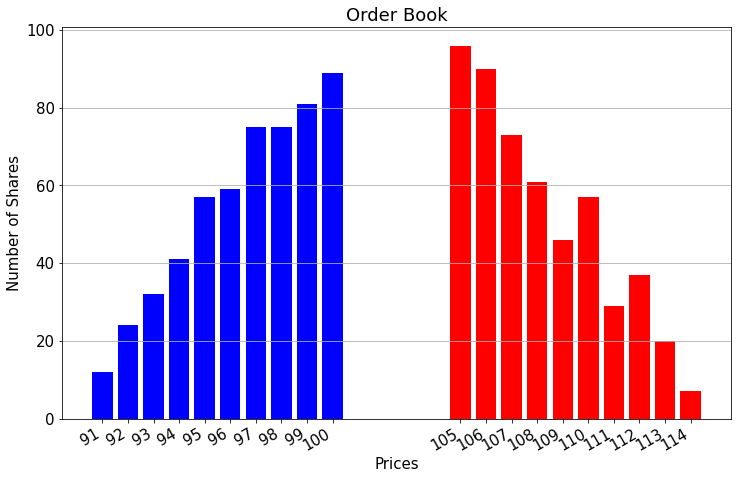

In [4]:
# Rewrite default order book with comments and in a more readable way
from numpy.random import poisson

bids: PriceSizePairs =[]
for i in range(100, 90, -1):
    # Sets Dollar amount and number of shares to buy
    this_dollars = i
    this_shares = poisson(100. - (100 - i) * 10) 
    # Puts values into DollarsAndShares container
    this_bid = DollarsAndShares(dollars=this_dollars,  shares=this_shares)
    # Appends bid to list of bids
    bids.append(this_bid)

asks: PriceSizePairs =[]
for i in range(105, 115, 1):
    # Sets Dollar amount and number of shares to sell
    this_dollars = i
    this_shares = poisson(100. - (i - 105) * 10)
    # Puts values into DollarsAndShares container
    this_bid = DollarsAndShares(dollars=this_dollars,  shares=this_shares)
    # Appends ask to list of bids
    asks.append(this_bid)  

    
ob0: OrderBook = OrderBook(descending_bids=bids, ascending_asks=asks)
ob0.display_order_book()
start_state_distribution = Constant(ob0)

## Model 1 Regular and Average

In [58]:
@dataclass(frozen=True)
class Order_Book_Model_1(MarkovProcess[OrderBook]):
    # Regular and Average
    # The next transaction is either a market order or limit order given by prob_market_order
    # The next transaction is either a buy or sell given by prob_buy
    # The next transaction price is chosen randomly from a range either inside or outside the spread given by prob_in_spread
    # If outside the spread, the value is chosen randomly from the range existing bid/ask prices not inside the spread
    # The number of shares of the next transaction is chosen as the average of shares of all prices values +- a spacing
    
    prob_buy:          float
    prob_market_order: float 
    prob_in_spread:    float
    
    def transition(self, state:OrderBook) -> Optional[SampledDistribution[OrderBook]]:
        """
        Fills in the abstract class transition which takes a state and returns a sampled distribution of the next state
        In the simulate function transition will be called and then sampled so a sampler function needs to be written 
        so that the next orderbook state is a result of the specified market dynamics mentioned above
        """
        descending_bids: PriceSizePairs = state.descending_bids
        ascending_asks: PriceSizePairs = state.ascending_asks
        
        # Gets a list of share values for the bids and asks
        bid_list_shares = [dollar_share.shares for dollar_share in descending_bids]
        ask_list_shares = [dollar_share.shares for dollar_share in ascending_asks]
        
        # Terminal state if no bids or asks left
        if len(bid_list_shares) == 0 or len(ask_list_shares) == 0:
            return None
        
        def my_killer_sampler(
            bid_list_shares = bid_list_shares,
            ask_list_shares = ask_list_shares,
            state: OrderBook = state
                                                    ) -> OrderBook:
            """
            Samples a distribution of possible next state order books and returns a single next state
            """
            # Puts all bids and asks into a single list
            all_bid_asks = descending_bids + ascending_asks

            # Gets the average number of shares
            average = sum(pair.shares for pair in all_bid_asks)//len(all_bid_asks)
            
            spacer = 20 # Sets spacer
            
            # Will buy/sell the average number of shares
            shares2transact = np.random.choice([share for share in range(average - spacer, average + spacer + 1)])
            
            # Clearly sets booleans
            Buying:       bool = np.random.random() < self.prob_buy
            Selling:      bool = not Buying
            Market_Order: bool = np.random.random() < self.prob_market_order
            Limit_Order:  bool = not Market_Order   
            In_Spread:    bool = np.random.random() < self.prob_in_spread
                
            if In_Spread:
                # Will buy/sell at this range of prices
                prices2transact = np.random.choice([i for i in range(state.bid_price() - spacer, state.ask_price() + spacer + 1)])
            else: # Not in the spred
                # Will buy/sell at this range of prices
                prices2transact = not_in_spread_list = bid_list_shares + ask_list_shares

            # Randomly chooses the price to transact
            super_price = np.random.choice(prices2transact)
            
            if Market_Order and Buying:
                _, next_state = state.buy_market_order(shares2transact)
                print(f"Buying {shares2transact} shares")
                
            elif Market_Order and Selling:
                _, next_state = state.sell_market_order(shares2transact)
                print(f"Selling {shares2transact} shares")
                
            elif Limit_Order and Buying:
                _, next_state = state.buy_limit_order(super_price, shares2transact)
                print(f"Buying {shares2transact} shares for ${super_price}")
                
            elif Limit_Order and Selling:
                _, next_state = state.sell_limit_order(super_price, shares2transact)
                print(f"Selling {shares2transact} shares for ${super_price}")
                
            else: # Catch all in case of errors
                raise("""The Market can only do so much sir.  This isn't some hippie
                      establishment where we all sing Kumbaya""")
#             print("Order Book \n", next_state, end="\n\n")
            return next_state

        return SampledDistribution(sampler=my_killer_sampler)

Selling 105 shares for $94
Buying 32 shares for $110
Selling 81 shares for $96
Selling 73 shares
Selling 96 shares for $113
Buying 74 shares
Buying 16 shares for $101
Selling 64 shares for $92
Selling 48 shares
Buying 40 shares
Selling 116 shares for $113
Selling 84 shares
Buying 58 shares
Selling 196 shares for $103
Buying 99 shares for $92
Selling 202 shares
Selling 144 shares for $82


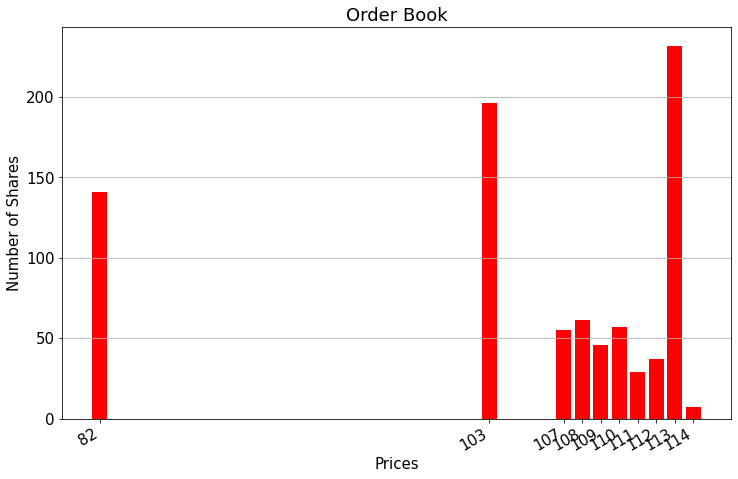

Selling 47 shares
Buying 23 shares
Selling 53 shares
Buying 54 shares
Selling 95 shares for $109
Selling 137 shares for $113
Buying 124 shares
Buying 103 shares
Buying 112 shares
Buying 123 shares for $98
Selling 31 shares for $107
Selling 65 shares for $117
Buying 70 shares
Selling 87 shares
Selling 85 shares
Selling 48 shares
Buying 81 shares
Buying 83 shares for $109
Selling 35 shares for $121
Selling 106 shares for $107
Buying 66 shares
Buying 112 shares
Buying 52 shares for $120
Selling 48 shares
Selling 15 shares
Selling 51 shares
Selling 28 shares for $116
Buying 9 shares for $103
Selling 30 shares
Buying 71 shares
Buying 64 shares for $94
Selling 103 shares
Selling 62 shares
Buying 49 shares
Selling 53 shares for $85
Selling 29 shares for $131
Selling 27 shares
Buying 36 shares for $124
Selling 38 shares
Buying 20 shares for $107
Buying 37 shares for $116
Buying 29 shares


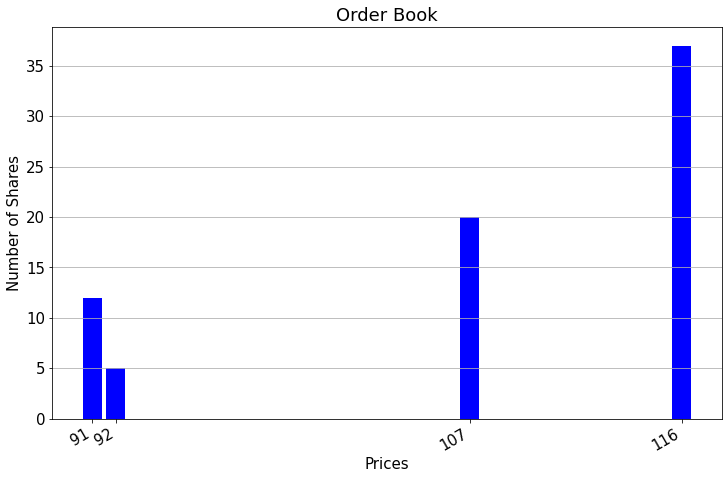

Buying 20 shares for $108
Buying 96 shares for $95
Selling 14 shares
Selling 8 shares for $101
Buying 69 shares
Buying 121 shares
Selling 68 shares
Buying 52 shares for $95
Buying 91 shares
Buying 122 shares
Buying 205 shares


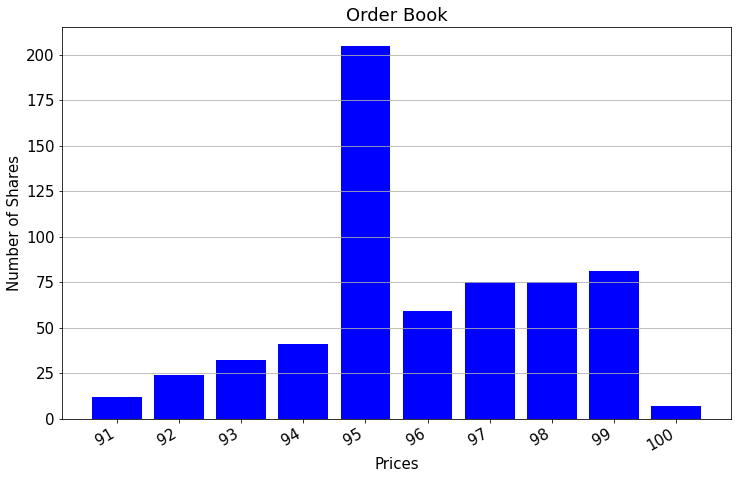

Selling 29 shares for $109
Selling 78 shares for $110
Selling 121 shares
Selling 66 shares
Selling 77 shares
Buying 74 shares for $101
Selling 76 shares for $97
Buying 71 shares for $107
Selling 74 shares
Buying 87 shares
Selling 21 shares
Selling 88 shares for $113
Selling 65 shares
Selling 101 shares
Buying 22 shares
Buying 92 shares
Buying 118 shares
Selling 8 shares for $85
Selling 46 shares


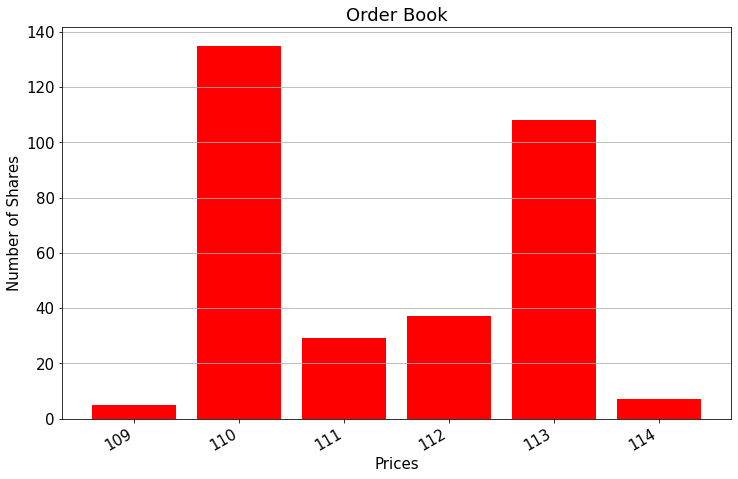

Selling 101 shares for $105
Selling 171 shares for $106
Buying 29 shares for $110
Buying 261 shares
Buying 19 shares
Selling 28 shares for $100
Selling 132 shares
Selling 114 shares
Buying 11 shares for $113
Buying 110 shares for $101
Selling 12 shares for $107
Buying 137 shares
Selling 90 shares
Selling 77 shares for $116
Selling 7 shares
Selling 47 shares for $106
Buying 83 shares
Selling 75 shares for $94
Selling 17 shares for $90
Buying 46 shares for $109
Buying 50 shares for $91
Selling 85 shares
Buying 7 shares for $92
Buying 59 shares for $91
Buying 63 shares
Buying 116 shares for $85
Buying 105 shares for $92
Selling 144 shares
Selling 123 shares
Selling 31 shares
Buying 42 shares for $110
Selling 34 shares
Selling 8 shares for $75
Buying 101 shares
Selling 70 shares
Buying 31 shares
Selling 8 shares
Buying 32 shares for $80
Selling 72 shares for $82
Selling 73 shares


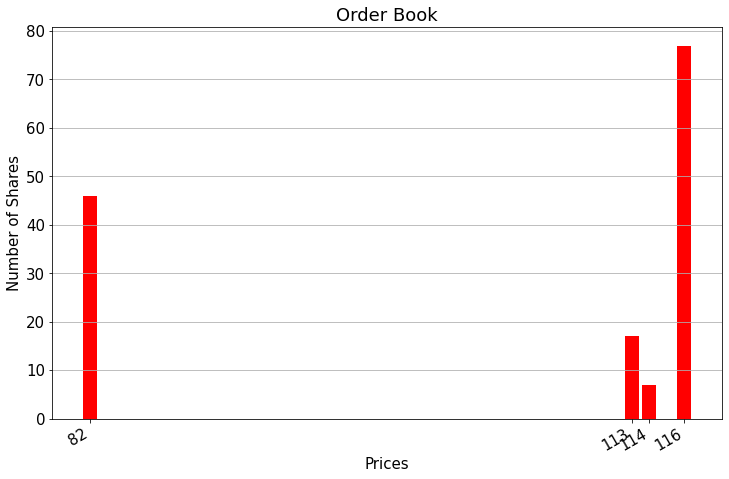

In [67]:
model1 = Order_Book_Model_1(prob_buy=0.5, prob_market_order=0.5, prob_in_spread=.5)

# Show 5 results of the simulations
for _ in range(5):
    simulation1 = model2.simulate(start_state_distribution)
    count = 1
    for iteration, book in enumerate(simulation1):
    #     print("\n\niteration: ", iteration, end='\n\n')
    #     print("book:\n", book, end='\n\n')

    #     book.pretty_print_order_book()
    #     book.display_order_book()

        count += 1
        if (count > 50):
            break 
    book.display_order_book()

Although trying to simulate a market at equilibrium, there still develops a chasm in the bid ask spread with possibly one direction winning out

## Model 2 Market of Dealers

In [68]:
@dataclass(frozen=True)
class Order_Book_Model_2(MarkovProcess[OrderBook]):
    # Market of Dealers
    # The next transaction is either a market order or limit order given by prob_market_order
    # The next transaction is either a buy or sell given by prob_buy
    # The next transaction price is chosen randomly from the range between the bid_ask spread +- a spacing
    # The number of shares of the next transaction is chosen randomly among all the range of the min and max shares for all the prices
    # The idea is that new market players are lookin to deal and want to transact close to the mid price
    
    prob_buy:          float
    prob_market_order: float 
    
    def transition(self, state:OrderBook) -> Optional[SampledDistribution[OrderBook]]:
        """
        Fills in the abstract class transition which takes a state and returns a sampled distribution of the next state
        In the simulate function transition will be called and then sampled so a sampler function needs to be written 
        so that the next orderbook state is a result of the specified market dynamics mentioned above
        """
        descending_bids: PriceSizePairs = state.descending_bids
        ascending_asks: PriceSizePairs = state.ascending_asks
             
        # Gets a list of dollar values for the bids and asks
        bid_list_dollars = [dollar_share.dollars for dollar_share in descending_bids]
        ask_list_dollars = [dollar_share.dollars for dollar_share in ascending_asks]
        
        # Terminal state if no bids or asks left
        if len(bid_list_dollars) == 0 or len(ask_list_dollars) == 0:
            return None
        
        def my_killer_sampler(
            bid_list_dollars = bid_list_dollars,
            ask_list_dollars = ask_list_dollars,
            state: OrderBook = state
                                                    ) -> OrderBook:
            """
            Samples a distribution of possible next state order books and returns a single next state
            """
            # Puts all bids and asks into a single list
            all_bid_asks = descending_bids + ascending_asks

            # Gets the max and min share values in the orderbook
            max_shares = max(all_bid_asks, key=lambda item: item.shares).shares
            min_shares = min(all_bid_asks, key=lambda item: item.shares).shares
            
            # Will buy/sell a random number min_shares:(max_share_value+10) shares
            shares2transact = np.random.randint(min_shares, max_shares+10)
            
            spacer = 10 # Sets spacer
            
            # Will buy/sell at this range of prices
            prices2transact = [i for i in range(state.bid_price() - spacer, state.ask_price() + spacer + 1)]
            
            
            # Randomly chooses the price to transact
            super_price = np.random.choice(prices2transact)
            
            # Clearly sets booleans
            Buying:       bool = np.random.random() < self.prob_buy
            Selling:      bool = not Buying
            Market_Order: bool = np.random.random() < self.prob_market_order
            Limit_Order:  bool = not Market_Order

            if Market_Order and Buying:
                _, next_state = state.buy_market_order(shares2transact)
                print(f"Buying {shares2transact} shares")
                
            elif Market_Order and Selling:
                _, next_state = state.sell_market_order(shares2transact)
                print(f"Selling {shares2transact} shares")
                
            elif Limit_Order and Buying:
                _, next_state = state.buy_limit_order(super_price, shares2transact)
                print(f"Buying {shares2transact} shares for ${super_price}")
                
            elif Limit_Order and Selling:
                _, next_state = state.sell_limit_order(super_price, shares2transact)
                print(f"Selling {shares2transact} shares for ${super_price}")
                
            else: # Catch all in case of errors
                raise("""The Market can only do so much sir.  This isn't some hippie
                      establishment where we all sing Kumbaya""")
#             print("Order Book \n", next_state, end="\n\n")
            return next_state

        return SampledDistribution(sampler=my_killer_sampler)

Buying 85 shares for $107
Selling 92 shares for $95
Buying 74 shares
Selling 31 shares for $95
Selling 43 shares for $116
Selling 83 shares for $93
Buying 61 shares for $109
Buying 17 shares
Selling 63 shares for $93
Selling 12 shares
Buying 39 shares for $108
Selling 44 shares for $92
Buying 10 shares
Selling 22 shares
Selling 10 shares for $101
Selling 23 shares for $88
Selling 12 shares for $88
Selling 28 shares
Buying 66 shares
Selling 23 shares
Buying 52 shares for $111
Buying 29 shares
Selling 44 shares
Selling 26 shares
Buying 52 shares
Buying 16 shares
Selling 8 shares
Buying 26 shares for $114
Selling 27 shares
Selling 9 shares for $84


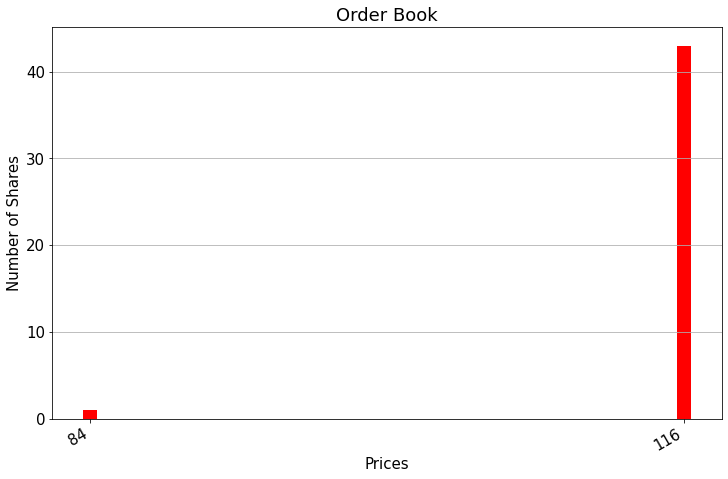

Buying 28 shares for $114
Selling 33 shares
Selling 11 shares
Buying 44 shares for $115
Buying 79 shares for $108
Buying 56 shares for $112
Selling 18 shares for $101
Buying 52 shares
Selling 54 shares
Selling 24 shares for $101
Buying 60 shares
Buying 60 shares
Buying 77 shares for $101
Buying 42 shares
Buying 46 shares for $118
Selling 46 shares
Buying 25 shares for $101
Buying 52 shares for $98
Buying 15 shares for $121
Selling 24 shares for $117
Buying 18 shares
Buying 89 shares


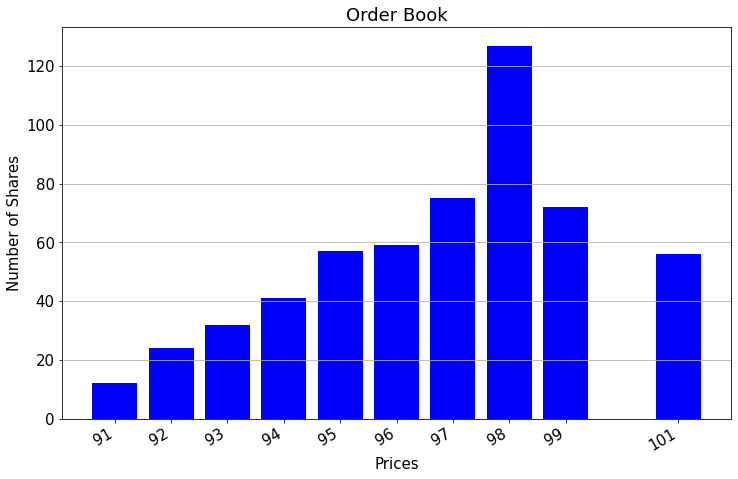

Selling 38 shares for $92
Buying 104 shares
Buying 60 shares for $102
Buying 34 shares for $101
Selling 39 shares
Selling 58 shares for $112
Selling 19 shares
Buying 11 shares for $109
Buying 54 shares for $97
Selling 8 shares
Selling 7 shares for $104
Buying 112 shares
Selling 48 shares
Selling 22 shares for $100
Selling 109 shares for $101
Selling 95 shares
Buying 39 shares for $96
Selling 62 shares for $88
Buying 106 shares
Buying 118 shares for $93
Selling 150 shares for $92
Buying 25 shares
Buying 36 shares
Buying 132 shares
Selling 28 shares for $103
Selling 121 shares
Buying 10 shares for $107
Selling 109 shares
Selling 63 shares for $103
Buying 97 shares for $105
Buying 102 shares for $95
Selling 7 shares
Buying 18 shares
Selling 84 shares
Buying 15 shares
Selling 38 shares
Selling 25 shares for $121
Selling 76 shares
Selling 67 shares


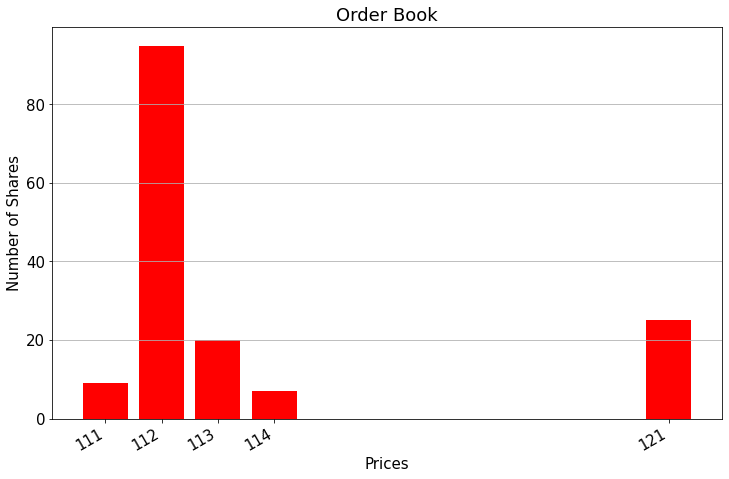

Buying 86 shares
Buying 29 shares for $97
Selling 42 shares for $114
Buying 106 shares for $99
Buying 129 shares for $100
Buying 177 shares for $100
Buying 364 shares for $95
Buying 152 shares for $94
Buying 265 shares for $98
Buying 361 shares for $109
Buying 347 shares for $118


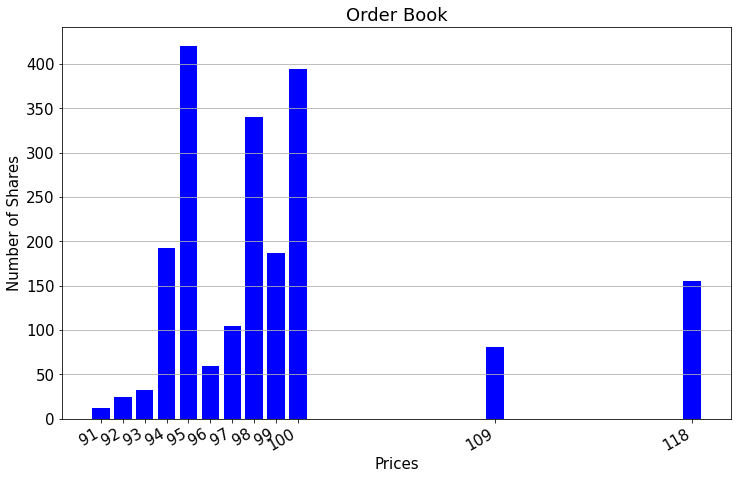

Buying 29 shares for $90
Selling 21 shares
Buying 18 shares
Buying 35 shares for $97
Buying 38 shares for $92
Selling 103 shares for $102
Selling 25 shares for $111
Selling 59 shares for $102
Selling 146 shares
Selling 71 shares for $95
Selling 81 shares for $94
Buying 85 shares
Selling 92 shares for $87
Selling 60 shares
Selling 53 shares for $88
Buying 53 shares for $103
Selling 13 shares
Buying 64 shares for $108
Buying 91 shares
Selling 54 shares for $103
Selling 80 shares for $105
Selling 87 shares for $84
Buying 78 shares for $104
Selling 68 shares for $104
Selling 59 shares for $110
Buying 78 shares for $103
Buying 90 shares
Buying 63 shares for $111
Buying 12 shares for $93
Buying 15 shares for $94
Selling 32 shares
Buying 72 shares for $102
Buying 111 shares
Selling 103 shares
Buying 125 shares for $92
Selling 119 shares
Buying 89 shares
Selling 12 shares for $110
Buying 39 shares for $98
Buying 17 shares
Buying 45 shares
Buying 57 shares for $120
Selling 56 shares for $119
Bu

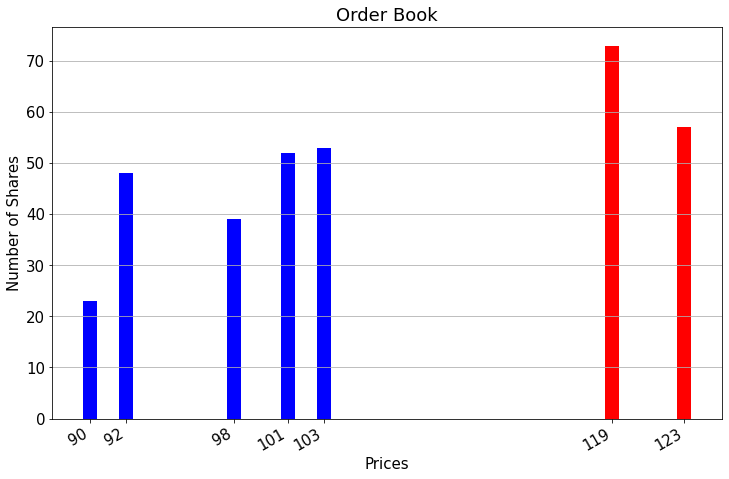

In [69]:
model2 = Order_Book_Model_2(prob_buy=0.5, prob_market_order=0.5)

# Show 5 results of the simulations
for _ in range(5):
    simulation2 = model2.simulate(start_state_distribution)
    count = 1
    for iteration, book in enumerate(simulation2):
    #     print("\n\niteration: ", iteration, end='\n\n')
    #     print("book:\n", book, end='\n\n')

    #     book.pretty_print_order_book()
    #     book.display_order_book()

        count += 1
        if (count > 50):
            break 
    book.display_order_book()

The Market of Dealers result shows that if the probability of a buying/selling at an even pace, there will be a very large bid ask spread since all the good deals get snapped up and any new orders are close to within the spread so they get consumed immediately

## Model 3 Fill In the Gap

In [76]:
@dataclass(frozen=True)
class Order_Book_Model_3(MarkovProcess[OrderBook]):
    # Fill in the gap
    # The next transaction is either a market order or limit order given by prob_market_order
    # The next transaction is either a buy or sell given by prob_buy
    # The next transaction price is the bid price + 1 for a limit buy order and ask price - 1 for a limit sell order
    # The number of shares of the next transaction is chosen as the average of shares of all prices values +- a spacing
    # The idea is that limit order should aim to fill in the bid ask spread all the time
    
    prob_buy:          float
    prob_market_order: float 
    
    def transition(self, state:OrderBook) -> Optional[SampledDistribution[OrderBook]]:
        """
        Fills in the abstract class transition which takes a state and returns a sampled distribution of the next state
        In the simulate function transition will be called and then sampled so a sampler function needs to be written 
        so that the next orderbook state is a result of the specified market dynamics mentioned above
        """
        descending_bids: PriceSizePairs = state.descending_bids
        ascending_asks: PriceSizePairs = state.ascending_asks
             
        # Gets a list of dollar values for the bids and asks
        bid_list_dollars = [dollar_share.dollars for dollar_share in descending_bids]
        ask_list_dollars = [dollar_share.dollars for dollar_share in ascending_asks]
        
        # Terminal state if no bids or asks left
        if len(bid_list_dollars) == 0 or len(ask_list_dollars) == 0:
            return None
        
        def my_killer_sampler(
            bid_list_dollars = bid_list_dollars,
            ask_list_dollars = ask_list_dollars,
            state: OrderBook = state
                                                    ) -> OrderBook:
            """
            Samples a distribution of possible next state order books and returns a single next state
            """
            # Puts all bids and asks into a single list
            all_bid_asks = descending_bids + ascending_asks
            
            # Gets the average number of shares
            average = sum(pair.shares for pair in all_bid_asks)//len(all_bid_asks)
#             print(average)
            
            spacer = 20 # Sets spacer
            
            # Will buy/sell the average number of shares
            shares2transact = np.random.choice([share for share in range(average - spacer, average + spacer + 1)])
#             print("bid", state.bid_price(), "ask", state.ask_price(), end="\n\n\n")
            # Clearly sets booleans
            Buying:       bool = np.random.random() < self.prob_buy
            Selling:      bool = not Buying
            Market_Order: bool = np.random.random() < self.prob_market_order
            Limit_Order:  bool = not Market_Order

            if Market_Order and Buying:
                _, next_state = state.buy_market_order(shares2transact)
                print(f"Buying {shares2transact} shares")
                
            elif Market_Order and Selling:
                _, next_state = state.sell_market_order(shares2transact)
                print(f"Selling {shares2transact} shares")
                
            elif Limit_Order and Buying:
                _, next_state = state.buy_limit_order(state.bid_price() + 1, shares2transact)
                print(f"Buying {shares2transact} shares for ${state.bid_price() + 1}")
                
            elif Limit_Order and Selling:
                _, next_state = state.sell_limit_order(state.ask_price() - 1, shares2transact)
                print(f"Selling {shares2transact} shares for ${state.ask_price() - 1}")
                
            else: # Catch all in case of errors
                raise("""The Market can only do so much sir.  This isn't some hippie
                      establishment where we all sing Kumbaya""")
#             print("Order Book \n", next_state, end="\n\n")
            return next_state

        return SampledDistribution(sampler=my_killer_sampler)

Buying 57 shares
Selling 38 shares
Selling 42 shares
Selling 51 shares for $104
Selling 30 shares
Buying 64 shares for $100
Selling 37 shares
Selling 48 shares
Selling 46 shares for $103
Selling 27 shares
Selling 36 shares for $102
Selling 28 shares for $101
Selling 42 shares for $100
Selling 53 shares
Selling 38 shares
Buying 33 shares
Buying 49 shares
Buying 41 shares for $98
Selling 25 shares for $101
Buying 51 shares for $99
Selling 25 shares
Buying 60 shares
Buying 34 shares
Selling 46 shares
Buying 57 shares for $99
Selling 43 shares for $102
Selling 55 shares
Selling 28 shares
Selling 54 shares
Selling 49 shares for $101
Selling 42 shares for $100
Buying 55 shares
Buying 43 shares for $98
Selling 24 shares
Buying 51 shares for $99
Buying 44 shares for $100
Buying 39 shares
Selling 36 shares for $101
Selling 31 shares
Buying 28 shares
Buying 40 shares
Selling 48 shares for $101
Selling 36 shares
Buying 33 shares for $100
Buying 52 shares
Selling 34 shares for $101
Buying 55 share

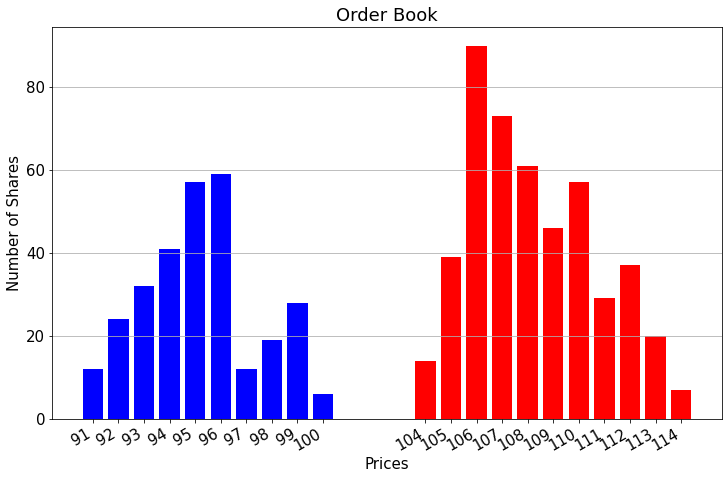

Selling 58 shares for $104
Selling 66 shares
Selling 52 shares
Buying 30 shares for $100
Selling 37 shares for $103
Selling 37 shares for $102
Selling 45 shares
Buying 61 shares
Buying 48 shares
Buying 46 shares
Selling 51 shares for $104
Selling 40 shares
Buying 40 shares
Selling 59 shares for $103
Buying 27 shares for $99
Selling 33 shares for $102
Buying 61 shares for $100
Selling 49 shares for $101
Buying 48 shares for $101
Buying 41 shares
Selling 43 shares
Selling 36 shares for $102
Selling 52 shares for $101
Buying 62 shares for $101
Selling 44 shares for $101
Buying 25 shares for $101
Buying 61 shares
Buying 36 shares
Buying 34 shares for $101
Selling 26 shares
Buying 55 shares
Buying 53 shares for $102
Buying 52 shares for $103
Selling 60 shares for $104
Selling 28 shares
Buying 25 shares
Selling 55 shares
Buying 24 shares
Selling 37 shares for $103
Buying 52 shares
Buying 60 shares for $103
Selling 41 shares
Selling 19 shares for $104
Buying 46 shares for $104
Buying 32 share

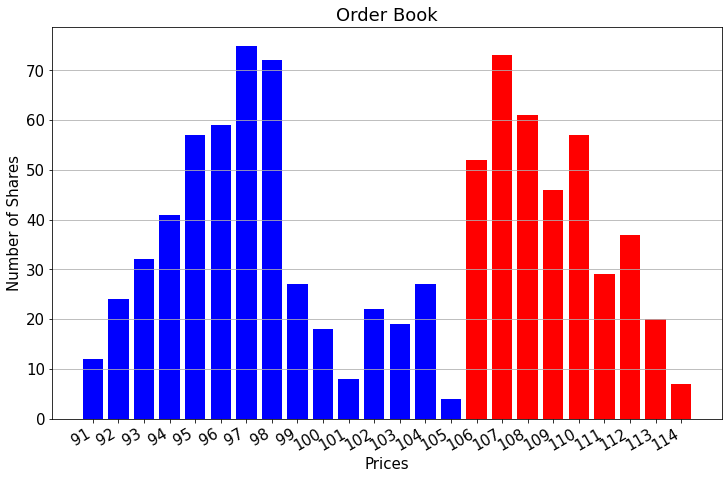

Selling 50 shares for $104
Selling 36 shares
Selling 47 shares
Selling 63 shares for $103
Buying 44 shares for $101
Buying 47 shares for $102
Selling 31 shares
Buying 53 shares
Buying 52 shares for $103
Buying 41 shares
Selling 28 shares
Selling 50 shares for $103
Selling 42 shares
Buying 49 shares
Buying 44 shares
Selling 46 shares for $104
Buying 25 shares
Buying 62 shares for $102
Buying 34 shares
Selling 50 shares for $104
Buying 30 shares for $103
Selling 57 shares
Buying 43 shares
Buying 47 shares for $103
Selling 40 shares
Buying 35 shares for $104
Selling 61 shares for $104
Selling 42 shares for $103
Selling 27 shares for $102
Selling 30 shares for $102
Buying 51 shares
Selling 50 shares for $102
Buying 37 shares for $102
Buying 40 shares for $102
Buying 32 shares for $103
Selling 38 shares for $103
Selling 41 shares for $102
Selling 46 shares
Selling 30 shares
Buying 30 shares
Buying 49 shares
Buying 30 shares
Selling 31 shares for $105
Buying 54 shares
Selling 26 shares for $

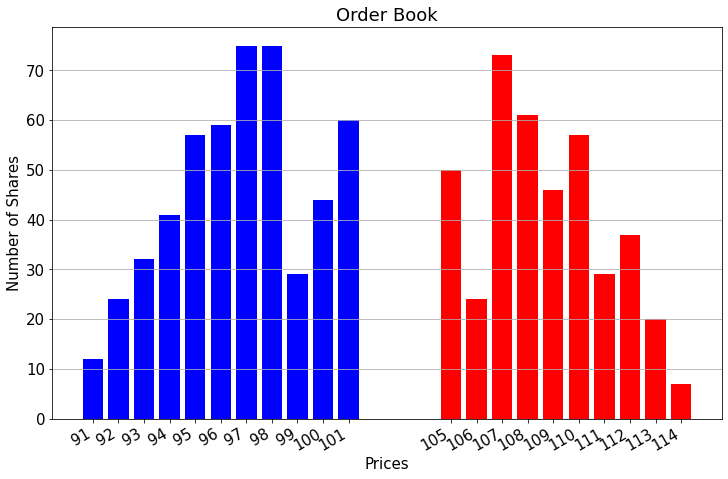

Buying 44 shares
Selling 64 shares for $104
Selling 61 shares
Selling 50 shares for $103
Selling 59 shares
Buying 54 shares
Selling 67 shares for $103
Buying 57 shares for $100
Buying 67 shares
Selling 61 shares for $103
Selling 60 shares
Selling 38 shares for $102
Selling 63 shares
Selling 56 shares for $101
Selling 27 shares
Buying 50 shares
Buying 55 shares
Buying 65 shares for $99
Selling 64 shares for $102
Buying 28 shares for $100
Buying 47 shares
Buying 38 shares
Buying 52 shares for $101
Buying 50 shares for $102
Buying 63 shares for $103
Selling 35 shares
Buying 29 shares for $103
Selling 26 shares for $103
Selling 62 shares
Selling 42 shares
Selling 56 shares
Buying 45 shares
Selling 24 shares
Selling 26 shares
Selling 58 shares
Selling 61 shares
Buying 24 shares for $97
Buying 54 shares for $98
Selling 55 shares
Selling 33 shares
Selling 48 shares for $103
Selling 41 shares for $102
Selling 50 shares for $101
Selling 43 shares for $100
Selling 38 shares
Selling 57 shares
Buy

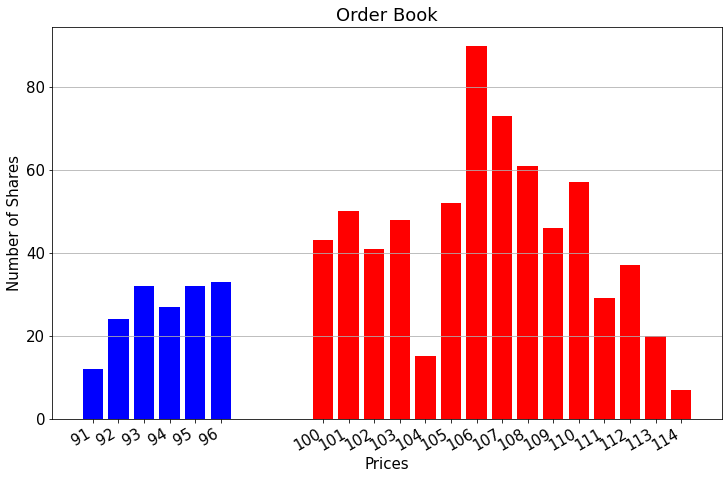

Buying 73 shares
Buying 31 shares for $101
Buying 60 shares
Buying 48 shares
Selling 46 shares for $105
Selling 46 shares
Buying 47 shares
Buying 44 shares
Buying 41 shares
Buying 47 shares
Buying 41 shares for $101
Selling 48 shares
Buying 50 shares for $101
Buying 44 shares for $102
Buying 62 shares for $103
Selling 26 shares
Selling 48 shares for $107
Selling 23 shares
Selling 34 shares
Selling 56 shares for $106
Buying 38 shares
Buying 32 shares
Selling 33 shares for $106
Selling 28 shares for $105
Buying 29 shares
Selling 26 shares for $105
Buying 28 shares
Selling 56 shares
Selling 28 shares
Buying 55 shares for $101
Buying 41 shares
Buying 33 shares
Buying 61 shares for $102
Buying 63 shares
Buying 57 shares for $103
Buying 43 shares for $104
Selling 61 shares for $109
Buying 60 shares for $105
Buying 29 shares for $106
Selling 44 shares
Selling 25 shares for $108
Buying 53 shares for $106
Selling 61 shares for $107
Buying 62 shares for $107
Buying 50 shares
Selling 49 shares fo

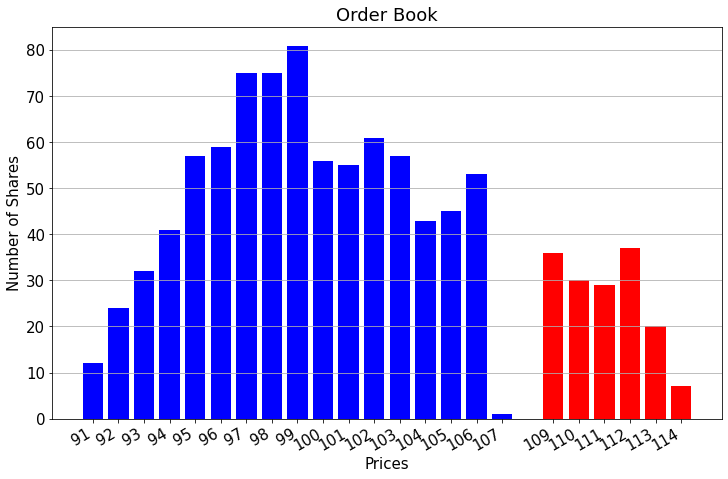

In [92]:
model3 = Order_Book_Model_3(prob_buy=0.5, prob_market_order=0.5)

# Show 5 results of the simulations
for _ in range(5):
    simulation3 = model3.simulate(start_state_distribution)
    count = 1
    for iteration, book in enumerate(simulation3):
    #     print("\n\niteration: ", iteration, end='\n\n')
    #     print("book:\n", book, end='\n\n')

    #     book.pretty_print_order_book()
    #     book.display_order_book()

        count += 1
        if (count > 50):
            break 
    book.display_order_book()

This Fill In the Gap behavior looks more normal where the bid ask spread gets bigger but then shrinks in a sort of random walk of the mid price similar to stocks